# 作業 : (Kaggle)房價預測

# [作業目標]
- 試著模仿範例寫法, 在房價預測中, 觀察去除離群值的影響

# [作業重點]
- 觀察將極端值以上下限值取代, 對於分布與迴歸分數的影響 (In[5], Out[5])
- 觀察將極端值資料直接刪除, 對於分布與迴歸分數的影響 (In[6], Out[6])

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

data_path = 'data/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# np.log1p( ) 函數的應用
- 數據預處理時，首先可以對偏度比較大的數據用log1p函數進行轉化，使其更加服從高斯分佈，此步處理可能會使後續的分類結果得到一個好的結果。
- 平滑問題很容易處理掉，導致模型的結果達不到一定的標準，log1p( )能夠避免復值得問題 — 復值指一個自變量對應多個因變量。
- log1p( ) 的使用就像是一個數據壓縮到了一個區間，與數據的標準類似，其逆運算就是expm1的函數。
- log1p = log（x+1），當x較大時直接計算，當x較小時用泰勒展開式計算。

## Reference
https://www.twblogs.net/a/5bcb78ac2b7177796822b664

In [3]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

data_path = 'data/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')

train_Y = np.log1p(df_train['SalePrice'])
df = df_train.drop(['Id', 'SalePrice'] , axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



In [5]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


# 作業1
* 試著限制 '1樓地板面積(平方英尺)' (1stFlrSF) 欄位的上下限, 看看能否再進一步提高分數?

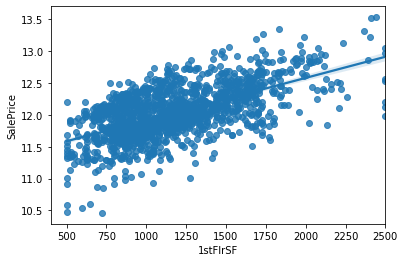

scores: [0.88741071 0.87058175 0.89024634 0.89773785 0.88828825]
scores的平均值為: 0.8868529812963668


In [9]:
# 顯示 1stFlrSF 與目標值的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x = df['1stFlrSF'][:train_num], y=train_Y) # sns.regplot:繪製線性回歸模型圖
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)  #fit_transform():先對partData作fit()的功能
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()
# 進行交叉焓驗證(用來驗證資料準確度)
scores = cross_val_score(estimator, train_X, train_Y, cv=5) #cv = 5 為將資料分成5組
print("scores:", scores)
print("scores的平均值為:",scores.mean())

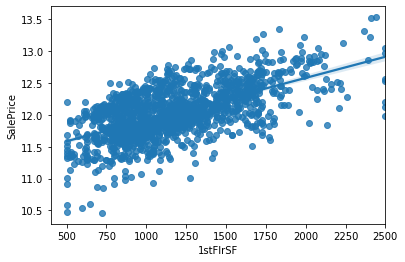

scores: [0.88741071 0.87058175 0.89024634 0.89773785 0.88828825]
scores的平均值為: 0.8868529812963668


In [10]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 調整離群值
"""
Your Code Here
"""
# 將 GrLivArea 限制在 500 到 2500 以內, 調整離群值
df['1stFlrSF'] = df['1stFlrSF'].clip(500, 2500) #clip函數:將串列中的元素限制在min,max之間，大於max的就使得它等於max，小於min,的就使得它等於min
sns.regplot(x = df['1stFlrSF'], y=train_Y)
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()
scores = cross_val_score(estimator, train_X, train_Y, cv=5) #cv = 5 為將資料分成5組
print("scores:", scores)
print("scores的平均值為:",scores.mean())

# 作業2
* 續前題, 去除離群值有兩類方式 :  捨棄離群值(刪除離群的資料) 以及調整離群值,  
請試著用同樣的上下限, 改為 '捨棄離群值' 的方法, 看看結果會變好還是變差? 並試著解釋原因。

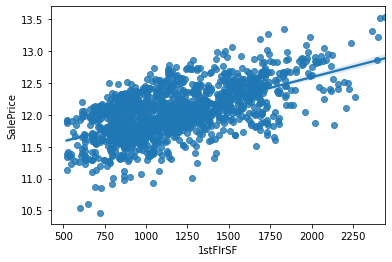

scores: [0.88883544 0.90036539 0.88840013 0.90022169 0.88945962]
scores的平均值為: 0.8934564523411981


In [11]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 捨棄離群值
"""
Your Code Here
"""
# 將 GrLivArea 限制在 500 到 2500 以內, 捨棄離群值
keep_indexs = (df['1stFlrSF']> 500) & (df['1stFlrSF']< 2500)
df = df[keep_indexs]
train_Y = train_Y[keep_indexs]
sns.regplot(x = df['1stFlrSF'], y=train_Y)
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean() 
scores = cross_val_score(estimator, train_X, train_Y, cv=5) # cv = 5 為將資料分成5組
print("scores:", scores)
print("scores的平均值為:",scores.mean())

依據上面2種case分析結果得知，改為「捨棄離群值」的方法，其擬合分數上升，預測結果會略為改善。